# Inteligent systems seminar 1

## Tree implementation

In [86]:
from abc import ABC, abstractmethod # abstract classes
import numpy as np # for fitness function
import random

# treat warnings as errors
import warnings
warnings.filterwarnings("error")


# base class
class Node(ABC):
    INT_ARRAY_SIZE = 1000
    P_GENERATION_X = 0.1
    P_ENDTREE_INIT = 0.3
    LONG_EQUATION_PENALTY = 0.0001
    ENABLE_EXTRA_OPERATORS = True

    @abstractmethod
    def evaluate(self, x):
        pass

    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def number_of_nodes(self):
        pass
    
    @abstractmethod
    def list_of_nodes(self):
        pass


# implementations of Node
class BinaryOperator(Node):
    def __init__(self, operator, left_child, right_child):
        self.parent = None
        self.operator = operator
        self.right_child = right_child
        self.left_child = left_child
        left_child.parent = self
        right_child.parent = self

    def evaluate(self, x):
        match(self.operator):
            case '+':
                return self.left_child.evaluate(x) + self.right_child.evaluate(x)
            case '-':
                return self.left_child.evaluate(x) - self.right_child.evaluate(x)
            case '*':
                return self.left_child.evaluate(x) * self.right_child.evaluate(x)
            case '/':
                return self.left_child.evaluate(x) / self.right_child.evaluate(x)
            case '^':
                return self.left_child.evaluate(x) ** self.right_child.evaluate(x)
            case 'max':
                return np.maximum(self.left_child.evaluate(x), self.right_child.evaluate(x))
            case 'min':
                return np.minimum(self.left_child.evaluate(x), self.right_child.evaluate(x))
            case _: # default case
                raise NotImplementedError()
            
    def __str__(self):
        return f"{self.operator} {self.left_child} {self.right_child}"
    
    def number_of_nodes(self):
        return 1 + self.left_child.number_of_nodes() + self.right_child.number_of_nodes()
    
    def list_of_nodes(self):
        return [self] + self.left_child.list_of_nodes() + self.right_child.list_of_nodes()


class UnaryOperator(Node):
    def __init__(self, operator, child):
        self.parent = None
        self.operator = operator
        self.child = child
        child.parent = self

    def evaluate(self, x):
        match(self.operator):
            case 'sin':
                return np.sin(self.child.evaluate(x))
            case 'cos':
                return np.cos(self.child.evaluate(x))
            case 'exp':
                return np.exp(self.child.evaluate(x))
            case 'log':
                return np.log(self.child.evaluate(x))
            case 'sqrt':
                return np.sqrt(self.child.evaluate(x))
            case 'abs':
                return np.abs(self.child.evaluate(x))
            case 'neg':
                return -self.child.evaluate(x)
            case _: # default case
                raise NotImplementedError()
            
    def __str__(self):
        return f"{self.operator} {self.child}"
    
    def number_of_nodes(self):
        return 1 + self.child.number_of_nodes()
    
    def list_of_nodes(self):
        return [self] + self.child.list_of_nodes()



class Number(Node):
    def __init__(self, value):
        self.parent = None
        self.value = value

    def evaluate(self, x):
        return self.value
    
    def __str__(self):
        return f"{self.value:.2f}"
    
    def number_of_nodes(self):
        return 1
    
    def list_of_nodes(self):
        return [self]



class X(Node):
    def __init__(self):
        self.parent = None
    
    def evaluate(self, x):
        return x
    
    def __str__(self):
        return "x"
    
    def number_of_nodes(self):
        return 1
    
    def list_of_nodes(self):
        return [self]



# probability
def P(p):
    return random.random() < p

def get_random_subtree(t):
    l = t.list_of_nodes()
    return random.choice(l)
    
def switch(s1, s2):
    p1 = s1.parent
    p2 = s2.parent
    
    if p1 is None or p2 is None:
        return
    
    if p1 is BinaryOperator:
        if p1.left_child == s1:
            p1.left_child = s2
        else:
            p1.right_child = s2
        
        if p2.left_child == s2:
            p2.left_child = s1
        else:
            p2.right_child = s1
    
    elif p1 is UnaryOperator:
        p1.child = s2
        p2.child = s1

    s1.parent = p2
    s2.parent = p1
    

def crossover_tree(t1, t2):
    s1 = get_random_subtree(t1)
    s2 = get_random_subtree(t2)
    
    switch(s1, s2)
    
    return t1, t2


def mutate_tree(t):
    l = t.list_of_nodes()
    s = random.choice(l)
    
    if isinstance(s, BinaryOperator):
        if not Node.ENABLE_EXTRA_OPERATORS:
            s.operator = random.choice(['+','-','*','/','^'])
        else:
            s.operator = random.choice(['+','-','*','/','^','max','min'])
    elif isinstance(s, UnaryOperator):
        s.operator = random.choice(['sin','cos','exp','log','sqrt','abs','neg'])
    elif isinstance(s, Number):
        s.value += random.choice([-1, 1])
    elif isinstance(s, X):
        pass
    else:
        raise NotImplementedError()
    
    return t


def generate_random_tree(P_ENDTREE = None):
    default_operators = ['+','-','*','/','^']
    extra_binary_operators = ['max','min']
    unary_operators = ['sin','cos','exp','log','sqrt','abs','neg']
    P_ENDTREE = Node.P_ENDTREE_INIT if P_ENDTREE == None else P_ENDTREE

    if P(P_ENDTREE):
        if P(Node.P_GENERATION_X):
            return X()
        return Number(random.randint(-10, 10))
    if not Node.ENABLE_EXTRA_OPERATORS:
        op = random.choice(default_operators)
    else:
        op = random.choice(default_operators + extra_binary_operators + unary_operators)
    if op in unary_operators:
        return UnaryOperator(
            op,
            generate_random_tree(P_ENDTREE * 1.1),
        )
    else:
        return BinaryOperator(
            op,
            generate_random_tree(P_ENDTREE * 1.1),
            generate_random_tree(P_ENDTREE * 1.1)
        )


# parser
def parsePolishNotationToTree(str):
    def parseTokensToTreePolish(tokens, idx):
        match(tokens[idx]):
            case '+' | '-' | '*' | '/' | '^' | 'max' | 'min': 
                operator = tokens[idx]
                idx = idx + 1

                left_child, idx = parseTokensToTreePolish(tokens, idx)
                right_child, idx = parseTokensToTreePolish(tokens, idx)

                return BinaryOperator(operator, left_child, right_child), idx
            case 'sin' | 'cos' | 'exp' | 'log' | 'sqrt' | 'abs' | 'neg':
                operator = tokens[idx]
                idx = idx + 1

                child, idx = parseTokensToTreePolish(tokens, idx)

                return UnaryOperator(operator, child), idx
            case 'x':
                # x = tokens[idx]
                idx = idx + 1
                return X(), idx
            case _:
                number = float(tokens[idx])
                idx = idx + 1
                return Number(number), idx
            
    tokens = str.split(' ')
    tree, _ = parseTokensToTreePolish(tokens, 0)
    return tree

# fitness function
def fitness(tree, xs, ys):
    try:
        fitness = -np.sum(np.square(ys - tree.evaluate(xs)))
    except:
        fitness = -np.inf
    
    if np.isfinite(fitness) and not np.iscomplexobj(fitness):
        penalty = Node.LONG_EQUATION_PENALTY * tree.number_of_nodes()
        return fitness * (1 + penalty) - penalty
    else:
        return -np.inf

def toIntArray(tree):
    bytes = str(tree).encode('utf-8')
    arr = np.zeros(Node.INT_ARRAY_SIZE, dtype=np.int8)
    for i in range(len(bytes)):
        arr[i] = bytes[i]
    return arr

def fromIntArray(arr):
    return parsePolishNotationToTree(arr.tobytes().decode('utf-8').replace('\x00', ''))

## Genetic algorithm

In [94]:
import numpy as np
import pygad
import csv
import matplotlib.pyplot as plt
import pickle
import os
import time

In [38]:
xs, ys, target = None, None, None

In [85]:
def fitness_func(ga_instance, solution, solution_idx):
  tree = fromIntArray(solution)
  fit = fitness(tree, xs, ys)
  return fit

def crossover_func(parents, offspring_size, ga_instance):
  offspring = []
  t1, t2 = fromIntArray(parents[0]), fromIntArray(parents[1])
  
  while len(offspring) != offspring_size[0]:
    child, _ = crossover_tree(t1, t2)

    try:
      offspring.append(toIntArray(child))
    except IndexError:
      print("Not crossovering")
    
  return np.array(offspring)

def mutation_func(offspring, ga_instance):
  new_offspring = []

  for t_numerical in offspring:
    t = fromIntArray(t_numerical)
    
    if (np.random.rand() < ga_instance.mutation_probability):
      t = mutate_tree(t)
    new_offspring.append(toIntArray(t))

  return np.array(new_offspring)

In [72]:
def predict_function(train_params):
    initial_population = [toIntArray(generate_random_tree()) for _ in range(5000)]

    ga_instance = pygad.GA(num_generations=train_params['num_generations'],
                        num_parents_mating=2,
                        initial_population=initial_population,
                        fitness_func=fitness_func,
                        keep_elitism=train_params['keep_elitism'],
                        crossover_type=crossover_func,
                        mutation_type=mutation_func,
                        gene_type=np.int8,
                        mutation_probability=train_params['mutation_probability'],
                        stop_criteria="saturate_10",
                        parallel_processing=20
                        )

    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    return fromIntArray(solution), solution_fitness

In [76]:
def train_on_dataset(equation_indices, skip_indices, dataset, best_models, train_params, extra_operators=False):
    global xs
    global ys
    
    Node.ENABLE_EXTRA_OPERATORS = extra_operators
    
    if os.path.exists(best_models):
        with open(best_models, "rb") as file:
            best_models = pickle.load(file)
    else:
        best_models = [(-float("inf"), None, None) for _ in range(100)]

    # for visualization purposes
    best_models_return = []

    with open(dataset) as file:
        reader = csv.reader(file)

        index = 1
        for row in reader:
            target = row[0]

            xs = np.fromstring(row[1][1:-1], sep=", ")
            ys = np.fromstring(row[2][1:-1], sep=", ")

            if index in skip_indices:
                index += 1
                continue

            if index in equation_indices:
                print("processing " + str(index))
                best_model, best_fitness = predict_function(train_params)
                best_models_return.append((best_fitness, best_model, target))
                if best_fitness > best_models[index][0]:
                    best_models[index] = (best_fitness, best_model, target)
            index += 1

    # save best models to file
    with open(best_models, 'wb') as file:
        pickle.dump(best_models, file)

    return best_models_return

In [77]:
dataset_file = "dataset.csv"
best_models_file = "best_models.pkl"

equation_indices = [1]
skip_indices = [36, 40]

train_params = {
    'mutation_probability': 1, 
    'keep_elitism': 10,
    'num_generations': 100
}

train_on_dataset(equation_indices, skip_indices, dataset_file, best_models_file, train_params, extra_operators=False)

processing 1
[(<__main__.Number object at 0x1206413d0>, -0.0001)]


In [79]:
# load predictions from file
with open('best_models.pkl', 'rb') as file:
    best_models = pickle.load(file)

In [78]:
def graph_predictions(best_models_filename, dataset_filename, indices, specific_model=None):
    # load predictions from file
    with open(best_models_filename, 'rb') as file:
        best_models = pickle.load(file)
    
    with open(dataset_filename) as file:
        reader = csv.reader(file)

        index = 1
        for row in reader:
            if index not in indices:
                continue

            target = row[0]

            xs = np.fromstring(row[1][1:-1], sep=", ")
            ys = np.fromstring(row[2][1:-1], sep=", ")
            
            if specific_model == None:
                fitness, model, target = best_models[index]
            else:
                fitness, model, target = specific_model

            if model != None:
                print("Target: ", target)
                print("Best solution", model)
                print("Best fitness", fitness)

                plt.title(f"Index: {index - 1}")
                plt.plot(xs, ys, color='green')
                plt.plot(xs, [model.evaluate(x) for x in xs], color='blue')
                plt.show()
            
            index += 1

## Dataset assesment

Target:  ((x ** 4) - 6)
Best solution + -6.00 ^ x 4.00
Best fitness -0.0005


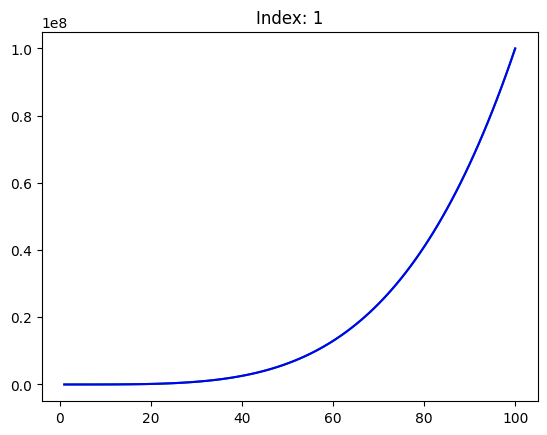

Target:  (((x / 8) * 2) + 1)
Best solution + - / + + -5.00 - -7.00 x -6.00 - - + - 4.00 8.00 3.00 3.00 1.00 7.00 7.00
Best fitness -209.3157375


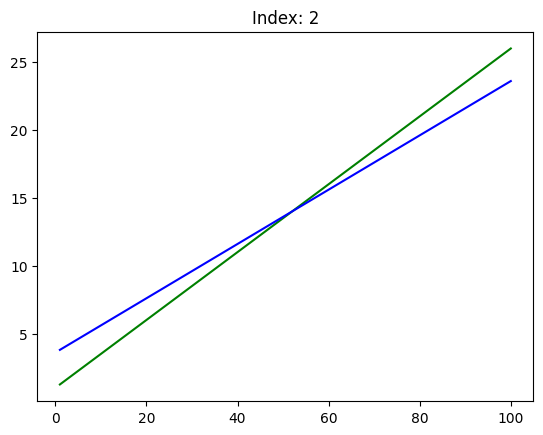

Target:  (((x - 1) - 3) / 5)
Best solution / x 5.00
Best fitness -64.01950000000001


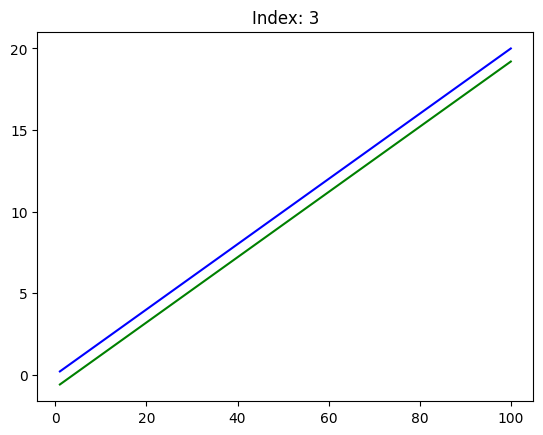

Target:  (x * 5)
Best solution * x 5.00
Best fitness -0.00030000000000000003


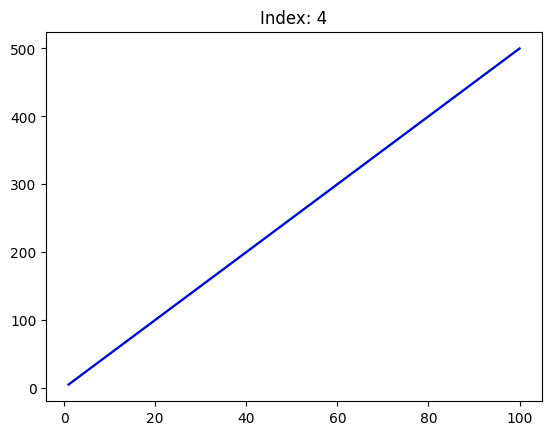

Target:  (x + 2)
Best solution - - x + -3.00 4.00 - * * -1.00 -3.00 ^ - -6.00 -5.00 9.00 / 0.00 * 5.00 ^ 6.00 5.00
Best fitness -0.0023


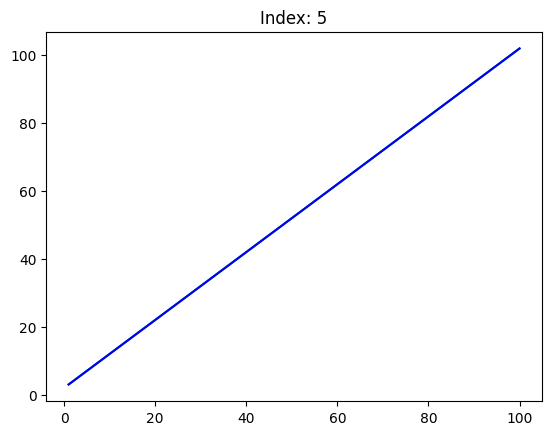

In [80]:
# indices = range(101)
indices = [94]

graph_predictions(best_models_filename='best_models.pkl', dataset_filename='dataset.csv', indices=indices)

## Extended mathematical operations 

Target:  sin x
Best solution sin x
Best fitness -0.0002


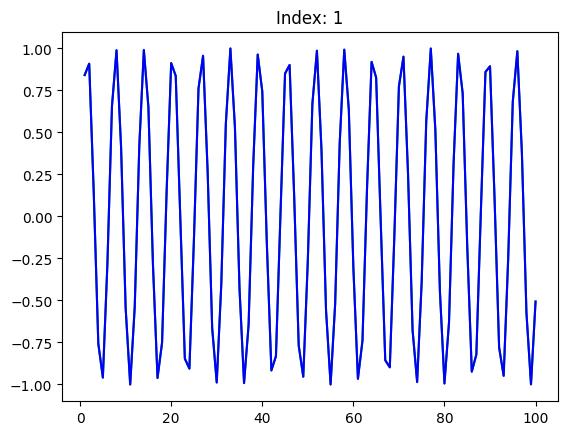

Target:  cos x
Best solution cos x
Best fitness -0.0002


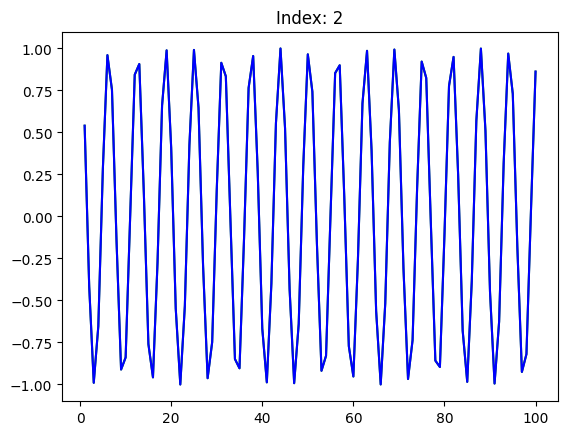

Target:  exp x
Best solution exp x
Best fitness -0.0002


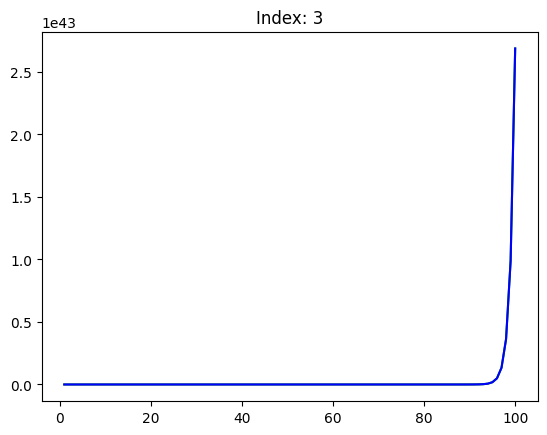

Target:  log x
Best solution log x
Best fitness -0.0002


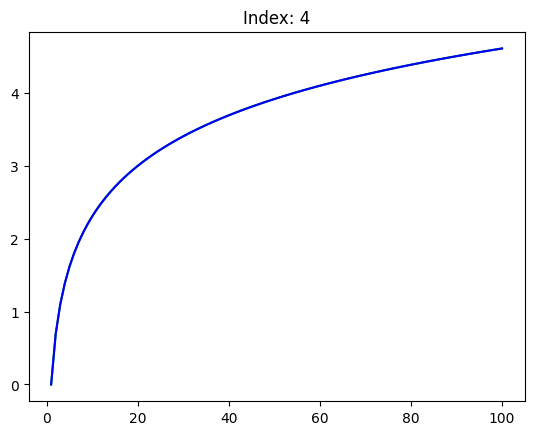

Target:  sqrt x
Best solution sqrt x
Best fitness -0.0002


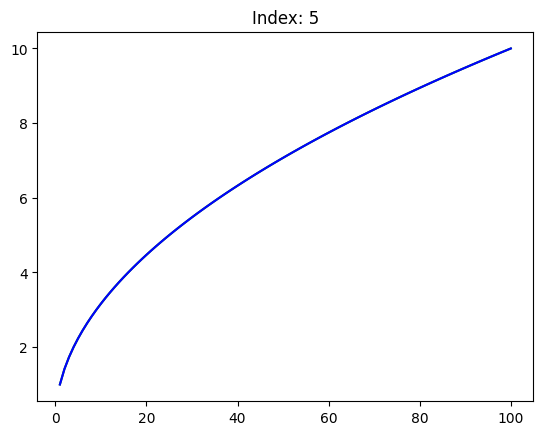

In [33]:
# indices = range(101)
indices = [1, 2, 3, 4, 5, 6]

graph_predictions(best_models_filename='best_models_custom.pkl', dataset_filename='custom_dataset.csv', indices=indices)

## Genetic algorithm configurations

In [ ]:
dataset_file = "dataset.csv"
best_models_file = "best_models.pkl"

equation_indices = [93]
skip_indices = []

train_params = {
    'mutation_probability': 1, 
    'keep_elitism': 10,
    'num_generations': 100
}

processing 99
processing 99
processing 99


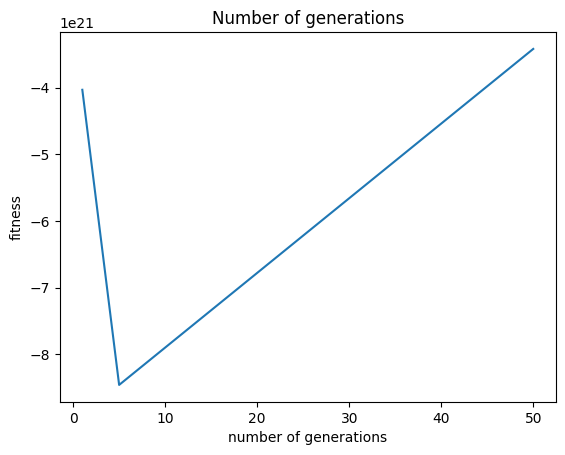

In [104]:
num_gen = [1, 5, 50]
fitness_for_n = []

for n in num_gen:
    train_params['num_generations'] = n
    res = train_on_dataset(equation_indices, skip_indices, dataset_file, best_models_file, train_params, extra_operators=False)
    fitness_for_n.append(res[0][1])

plt.title("Number of generations")
plt.xlabel('number of generations')
plt.ylabel('fitness')
plt.plot(num_gen, fitness_for_n)

processing 99
processing 99
processing 99


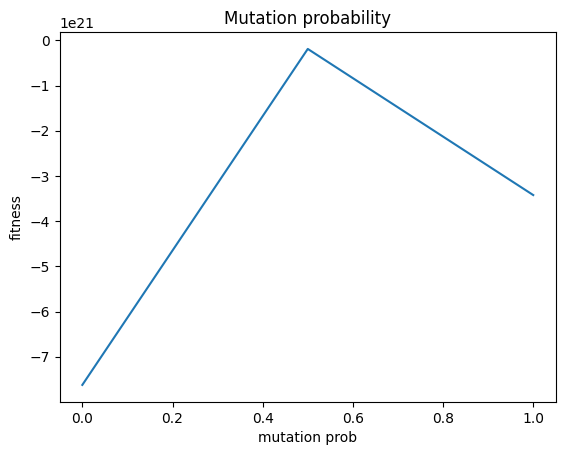

In [105]:
mutation_probabilities = [0, 0.5, 1]
fitness_for_n = []

for m in mutation_probabilities:
    train_params['mutation_probability'] = m
    res = train_on_dataset(equation_indices, skip_indices, dataset_file, best_models_file, train_params, extra_operators=False)
    fitness_for_n.append(res[0][1])

plt.title("Mutation probability")
plt.xlabel('mutation prob')
plt.ylabel('fitness')
plt.plot(mutation_probabilities, fitness_for_n)

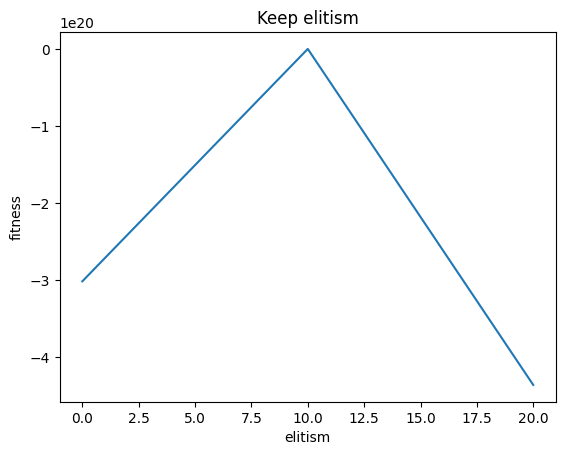

In [99]:
keep_elitism = [0, 10, 20]
fitness_for_n = []

for e in keep_elitism:
    train_params['keep_elitism'] = e
    res = train_on_dataset(equation_indices, skip_indices, dataset_file, best_models_file, train_params, extra_operators=False)
    fitness_for_n.append(res[0][1])

plt.title("Keep elitism")
plt.xlabel('elitism')
plt.ylabel('fitness')
plt.plot(keep_elitism, fitness_for_n)

## Time complexity

In [95]:
dataset_file = "dataset.csv"
best_models_file = "best_models.pkl"

equation_indices = []
skip_indices = []

train_params = {
    'mutation_probability': 1, 
    'keep_elitism': 10,
    'num_generations': 100
}

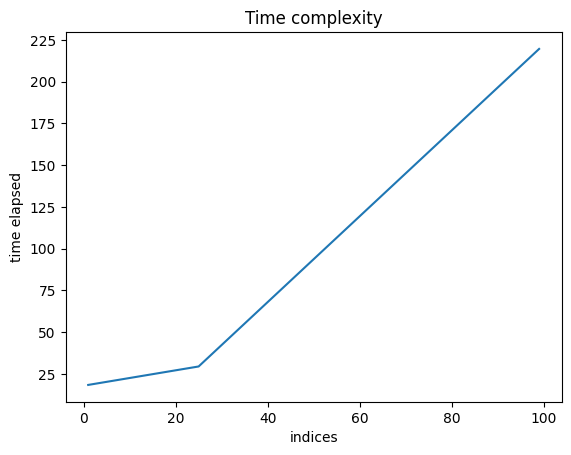

In [97]:
indices = [1, 25, 99]
time_elapsed = []

for i in indices:
    equation_indices = [i]
    skip_indices = []
    start = time.time()
    train_on_dataset(equation_indices, skip_indices, dataset_file, best_models_file, train_params, extra_operators=False)
    end = time.time()
    time_elapsed.append(end - start)

plt.title("Time complexity")
plt.xlabel('indices')
plt.ylabel('time elapsed')
plt.plot(indices, time_elapsed)